# NoiseTunnel

This Jupyter Notebook starts by importing the necessary Python libraries such as Torch, Torchvision, PIL, requests, NumPy, and Captum. It then loads the VGG11 pre-trained model and sets it to evaluation mode.

Next, it defines a transformation pipeline for the input image which includes resizing, center cropping, and converting the image to a tensor. It also normalizes the image using mean and standard deviation values specific to the ImageNet dataset. The input image is then loaded and transformed.

The notebook uses Integrated Gradients and  Noise Tunnel to generate attribution maps to understand the contribution of different regions of the image towards the model's output and visualizes the results using Captum's visualization functions.

The goal of this notebook is to provide a basic understanding of the different attribution methods available in Captum and to showcase how to use them to analyze the contribution of different parts of an input image towards a model's output.

This Jupyter notebook is based on:

* https://captum.ai/docs/attribution_algorithms#noise-tunnel
* https://captum.ai/docs/attribution_algorithms#integrated-gradients
* http://arxiv.org/abs/1703.01365

#### Installing Captum Library

The following line installs version 0.6.0 of the Captum library.

This version is used because it is compatible with the other libraries used in this notebook.

In [1]:
!pip install matplotlib==3.6 captum==0.6.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 19.2 MB/s eta 0:00:00
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.7.1
    Uninstalling matplotlib-3.7.1:
      Successfully uninstalled matplotlib-3.7.1


#### Configuring Matplotlib for Displaying Images

The following line configures Matplotlib to display images without padding.

This configuration is necessary because Matplotlib adds padding around images by default, which can affect the layout of the notebook. Setting the `bbox_inches` parameter to `None` removes the padding and ensures that images are displayed at their original size without any cropping or scaling.

In [2]:
%config InlineBackend.print_figure_kwargs={'bbox_inches':None}

#### Using NoiseTunnel with Integrated Gradients
This cell imports necessary libraries and loads a pre-trained VGG11 model for image classification. It applies Integrated Gradients and  Noise Tunnel to visualize important features of an input image for classification. The script also checks if a GPU is available, defines a baseline for some attribution methods, and smoothens the attribution maps using NoiseTunnel.

In [4]:
import torch
import torchvision.transforms as transforms
from torchvision import models
from PIL import Image
import requests
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from captum.attr import visualization as viz
from captum.attr import IntegratedGradients, NoiseTunnel
from matplotlib.colors import LinearSegmentedColormap
import torch.nn.functional as F

# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Using device:', device)

# Load the model and set it to evaluation mode
model = models.vgg11(pretrained=True)
model.to(device)
model.eval()

transform = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(112),
    transforms.ToTensor()
])

transform_normalize = transforms.Normalize(
    mean=[0.485, 0.456, 0.406],
    std=[0.229, 0.224, 0.225]
)

img = Image.open('/content/drive/MyDrive/Colab Notebooks/images/green_traffic_light.jpg')

transformed_img = transform(img)

input_img = transform_normalize(transformed_img)
input_img = input_img.unsqueeze(0)
input_img = input_img.to(device)

# Define the baseline for Integrated Gradients
baseline = torch.zeros_like(input_img)

# Define the IntegratedGradients and Noise Tunnel attribution methods
ig = IntegratedGradients(model)
nt = NoiseTunnel(ig)

# Compute the attribution maps using Integrated Gradients and Noise Tunnel
target = torch.argmax(model(input_img))
print(target)

# Make predictions with the model
outputs = model(input_img)
output_probs = F.softmax(outputs, dim=1).squeeze(0)
# Find the index of the maximum value
label_idx = output_probs.argmax()
# Get the corresponding probability
probability = output_probs[label_idx].item() * 100 # converting to percentage
print(f"Label Index: {label_idx}, Probability: {probability:.2f}%")

with torch.no_grad():
    attr_ig = ig.attribute(input_img, baseline, target=target)
    # Use NoiseTunnel to smooth the attribution maps
    attr_ig_smooth = nt.attribute(input_img, nt_type='smoothgrad', nt_samples=1, stdevs=0.1, target=target)

Using device: cuda
tensor(920, device='cuda:0')
Label Index: 920, Probability: 100.00%


#### XAI metrics

A low infidelity value close to 0 indicates that the explanation provided by the XAI method is relatively faithful to the model's behavior. It suggests that the generated explanation is a good representation of how the model arrived at its predictions, making it a reliable and accurate explanation.

A high sensitivity value close indicates that the model is highly sensitive to changes in specific input features. In other words, small changes in those features can lead to substantial changes in the model's predictions. This suggests that the model heavily relies on the identified features to make its decisions.

In [ ]:
from captum.metrics import infidelity, sensitivity_max
import numpy as np

# Define the perturbation function
def perturb_fn(inputs):
    # Multiplying by 0.003 scales the random values to control the magnitude of the perturbations.
    noise = torch.tensor(np.random.normal(0, 0.003, inputs.shape)).float().to(device)
    return noise, inputs - noise

# Compute the infidelity
infid = infidelity(model, perturb_fn, input_img, attr_ig_smooth, target=target)

print(f"Infidelity: {infid.item()}")

# Wrapper function
def ig_smooth_attr(inputs):
    return nt.attribute(inputs, nt_type='smoothgrad', nt_samples=1, stdevs=0.1, target=target)

# Calculate Sensitivity
sens = sensitivity_max(ig_smooth_attr, input_img)
print(f"Sensitivity: {sens.item()}")

Infidelity: 0.00796238266747241
Sensitivity: 1.2816667099412455


#### Visualization

The Integrated Gradients and Noise Tunnel resulting attribution maps are visualized with a color map and a color bar, and each map is given a title corresponding to the method used.

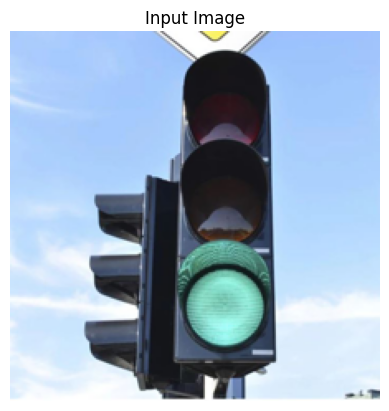

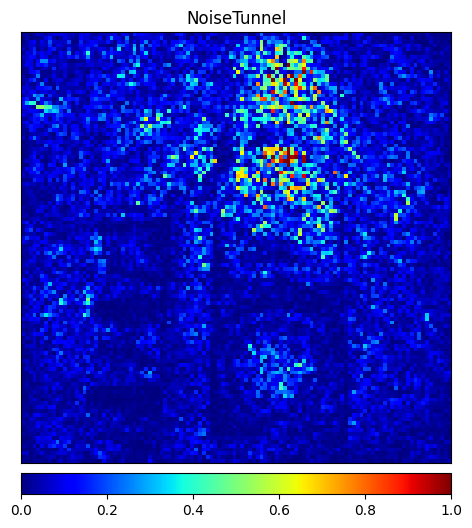

In [ ]:
plt.axis('off')
plt.imshow(img.resize((224, 224)))
plt.title('Input Image')
plt.show()

# Visualize the attribution maps
_ = viz.visualize_image_attr(np.transpose(attr_ig_smooth.squeeze().cpu().detach().numpy(), (1,2,0)), show_colorbar=True, title='NoiseTunnel', method="heat_map", cmap='jet')